In [1]:
import cv2
import pandas as pd
import numpy as np
from skimage import io
import sys  
cv2.__version__

'4.5.5'

In [2]:
def get_face_data(file_path):
    """
    input
        file_path in format of '[age]_[gender]_[race]_[date&time].jpg' as is the format of UTK Face dataset
    output:
        face_dict  dictionary with identifying characteristics
    """
    face_str_split = file_path.split('_')
    if(face_str_split[1]=='0'):
        gender = 'male'
    else:
        gender = 'female'
    
    race_group_num = face_str_split[2]
    #set race
    if face_str_split[2]=='0':
        race='white'
    elif face_str_split[2]=='1':
        race = 'black'
    elif face_str_split[2]=='2':
        race='asian'
    elif face_str_split[2]=='3':
        race='indian'
    else:
        race='other'
    face_dict = {'gender':gender,'race':race,'path':face_str}
    
    return face_dict


In [3]:
#regular face data random picking - expected to be biased towards white
import os, random
#normalization open cv
random_face_group = []
num_picks = 2000
for i in range(num_picks):
    face_str = random.choice(os.listdir('UTKFace'))
    face_dict = get_face_data(face_str)
    random_face_group.append(face_dict)

In [4]:
#balanced random face group such that we have an equal distribution of all races
balanced_random_face_group = [[],[],[],[],[]]
num_picks = 2000
distribution_per_group = num_picks/len(balanced_random_face_group)
total_face_count = 0

#this will be inifnite if the distribution for group is not properly divisible by the total number of pics. 
while total_face_count < num_picks:
    # has chance of repeats - this is ok!
    face_str = random.choice(os.listdir('UTKFace'))
    race_group_num = int(face_str.split('_')[2])
    if(len(balanced_random_face_group[race_group_num]) < distribution_per_group):
        face_dict = get_face_data(face_str)
        balanced_random_face_group[race_group_num].append(face_dict)
        total_face_count+=1
balanced_random_face_group = list(np.concatenate(balanced_random_face_group).flat)
    

In [5]:
balanced_random_face_group

[{'gender': 'male',
  'race': 'white',
  'path': '37_0_0_20170119202225685.jpg.chip.jpg'},
 {'gender': 'female',
  'race': 'white',
  'path': '1_1_0_20170110212607474.jpg.chip.jpg'},
 {'gender': 'female',
  'race': 'white',
  'path': '42_1_0_20170103184125771.jpg.chip.jpg'},
 {'gender': 'female',
  'race': 'white',
  'path': '58_1_0_20170110132501568.jpg.chip.jpg'},
 {'gender': 'female',
  'race': 'white',
  'path': '21_1_0_20170103201838744.jpg.chip.jpg'},
 {'gender': 'male',
  'race': 'white',
  'path': '37_0_0_20170120221604091.jpg.chip.jpg'},
 {'gender': 'female',
  'race': 'white',
  'path': '13_1_0_20170109204439327.jpg.chip.jpg'},
 {'gender': 'male',
  'race': 'white',
  'path': '42_0_0_20170117185635954.jpg.chip.jpg'},
 {'gender': 'female',
  'race': 'white',
  'path': '35_1_0_20170116203950507.jpg.chip.jpg'},
 {'gender': 'male',
  'race': 'white',
  'path': '16_0_0_20170110231814139.jpg.chip.jpg'},
 {'gender': 'female',
  'race': 'white',
  'path': '16_1_0_20170109214102958.jp

In [6]:
import matplotlib.pyplot as plt

def plot_distriction(face_group):
        """plots the distribution of races, also with dinstinction of men and women."""

        ##0: white, 1: black, 2: Asian, 3: Indian, 4: other
        men = [0,0,0,0,0]
        women = [0,0,0,0,0]
        racial_categories = ['white','black','asian','indian','other']

        for person in face_group:
            race_val = 4
            if person['race']==racial_categories[0]:
                race_val = 0
            elif person['race']==racial_categories[1]:
                race_val = 1
            elif person['race']==racial_categories[2]:
                race_val = 2
            elif person['race']==racial_categories[4]:
                race_val = 3
            
            if person['gender']=='female':
                women[race_val]+=1
            elif person['gender']=='male':
                men[race_val]+=1

        num_races = len(racial_categories)
        width = 0.35

        fig = plt.figure()
        ax = fig.add_axes([0,0,1,1])
        ind = np.arange(num_races)

        ax.bar(ind,men,width, color='r')
        ax.bar(ind,women,width,bottom=men,color='b')
        ax.set_ylabel("number of samples")
        title = f'Demographic of sample size {num_picks}'
        ax.set_title(title)
        ax.set_xticks(ind,racial_categories)
        ax.legend(['men','women'])
        plt.show()

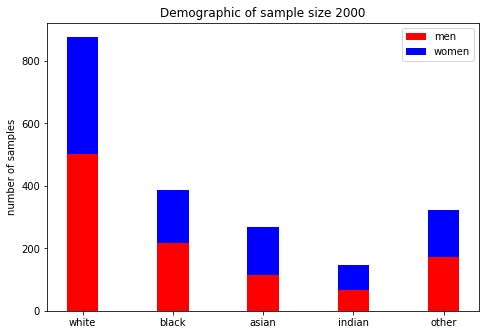

In [7]:
plot_distriction(random_face_group)

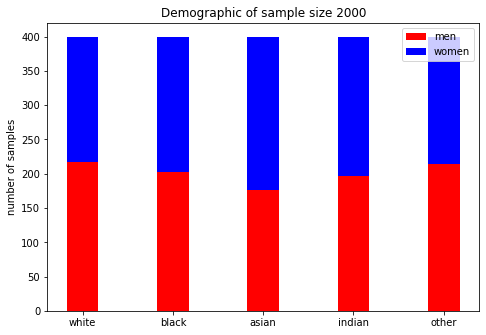

In [8]:
plot_distriction(balanced_random_face_group)

In [9]:
from matplotlib import image
from sklearn.preprocessing import StandardScaler
def get_img_data(face_group):
    """
    Converts input into a dataframe and adds image itself to the dataframe.
        image itself could not be stored in dictionary
    input: face_group: a list of dictionaries of faces
    output: face_df (dataframe)
    """

    face_df = pd.DataFrame.from_dict(face_group)

    img_data = {x:0 for x in range(len(face_df))}
    for idx, row in face_df.iterrows():
        relative_path = 'UTKFace\\'+str(row["path"])
        img = image.imread(relative_path)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        img_data[idx] = gray.flatten()

    face_df['img_data'] = pd.Series(img_data)
    print(f'shape img_data: {img_data[0].shape}')
    return face_df

In [10]:
unbal_face_df = get_img_data(random_face_group)
unbal_face_df

shape img_data: (40000,)


,gender,race,path,img_data
0,female,white,21_1_0_20170104020509980.jpg.chip.jpg,"[138, 133, 125, 114, 105, 101, 102, 104, 116, ..."
1,female,white,35_1_0_20170116235700676.jpg.chip.jpg,"[138, 139, 141, 144, 145, 146, 145, 145, 144, ..."
2,male,asian,45_0_2_20170112215145176.jpg.chip.jpg,"[26, 26, 24, 20, 18, 17, 18, 21, 21, 24, 25, 2..."
3,male,black,32_0_1_20170117172950046.jpg.chip.jpg,"[85, 79, 71, 66, 67, 71, 75, 78, 73, 66, 59, 5..."
4,female,black,29_1_1_20170113003505958.jpg.chip.jpg,"[29, 30, 31, 31, 32, 33, 37, 40, 43, 44, 46, 4..."
...,...,...,...,...
1995,male,black,61_0_1_20170113175415829.jpg.chip.jpg,"[219, 219, 219, 220, 220, 220, 219, 219, 216, ..."
1996,female,white,26_1_0_20170117201449668.jpg.chip.jpg,"[65, 64, 63, 61, 57, 53, 49, 47, 41, 36, 33, 3..."
1997,male,indian,46_0_3_20170119195336586.jpg.chip.jpg,"[4, 4, 3, 2, 2, 6, 12, 15, 19, 18, 18, 17, 15,..."
1998,female,black,36_1_1_20170113000900081.jpg.chip.jpg,"[167, 167, 167, 167, 167, 167, 167, 167, 168, ..."


In [11]:
bal_face_df = get_img_data(balanced_random_face_group)
bal_face_df

shape img_data: (40000,)


,gender,race,path,img_data
0,male,white,37_0_0_20170119202225685.jpg.chip.jpg,"[5, 10, 16, 21, 22, 20, 20, 20, 23, 21, 20, 24..."
1,female,white,1_1_0_20170110212607474.jpg.chip.jpg,"[172, 172, 172, 173, 173, 174, 174, 174, 174, ..."
2,female,white,42_1_0_20170103184125771.jpg.chip.jpg,"[148, 149, 151, 155, 158, 161, 164, 165, 163, ..."
3,female,white,58_1_0_20170110132501568.jpg.chip.jpg,"[31, 24, 45, 60, 42, 32, 42, 43, 42, 47, 52, 5..."
4,female,white,21_1_0_20170103201838744.jpg.chip.jpg,"[211, 139, 57, 54, 64, 60, 65, 40, 13, 5, 17, ..."
...,...,...,...,...
1995,male,other,20_0_4_20170117193437251.jpg.chip.jpg,"[27, 26, 24, 22, 21, 21, 22, 23, 32, 37, 44, 4..."
1996,female,other,12_1_4_20170103200721583.jpg.chip.jpg,"[54, 53, 51, 51, 52, 50, 47, 44, 46, 44, 41, 4..."
1997,female,other,26_1_4_20170117185535633.jpg.chip.jpg,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1998,female,other,5_1_4_20161221201952681.jpg.chip.jpg,"[48, 48, 48, 50, 53, 55, 55, 54, 52, 50, 47, 4..."


In [12]:
def get_train_mat(face_df):
    img_mat = np.empty((2000, 40000))
    for idx, row in enumerate(face_df['img_data']):
        img_mat[idx] = row

    print(f'shape: {img_mat.shape}')
    return img_mat

In [13]:
unbal_img_mat = get_train_mat(unbal_face_df)
unbal_img_mat[:10, :]

shape: (2000, 40000)


array([[138., 133., 125., ...,  48.,  52.,  56.],
       [138., 139., 141., ..., 123., 122., 124.],
       [ 26.,  26.,  24., ...,  39.,  44.,  47.],
       ...,
       [ 61.,  69.,  80., ..., 111., 108., 108.],
       [ 22.,  23.,  24., ...,  42.,  41.,  41.],
       [ 18.,  31.,  39., ..., 201., 200., 198.]])

In [14]:
bal_img_mat = get_train_mat(bal_face_df)
bal_img_mat[:10, :]

shape: (2000, 40000)


array([[  5.,  10.,  16., ..., 249., 248., 248.],
       [172., 172., 172., ..., 239., 239., 239.],
       [148., 149., 151., ...,  31.,  31.,  31.],
       ...,
       [ 17.,  21.,  29., ..., 102., 105., 108.],
       [ 47.,  46.,  47., ...,  56.,  56.,  56.],
       [  1.,   1.,   2., ..., 230., 230., 230.]])

In [15]:
# normalize pixel features in our image matrix
scaler = StandardScaler()
unbal_simg_mat = scaler.fit_transform(unbal_img_mat)
print(scaler.mean_)

unbal_simg_mat[:10, :]

[ 88.4025  87.663   86.5605 ... 105.0715 104.9465 105.129 ]


array([[ 0.70111887,  0.64734563,  0.55330434, ..., -0.75013729,
        -0.69396072, -0.64216815],
       [ 0.70111887,  0.7330168 ,  0.78361092, ...,  0.2356489 ,
         0.22351731,  0.24666399],
       [-0.88213257, -0.88045688, -0.90050589, ..., -0.86843163,
        -0.79881535, -0.7598077 ],
       ...,
       [-0.3873665 , -0.26648017, -0.09443289, ...,  0.07792311,
         0.0400217 ,  0.03752702],
       [-0.93867726, -0.92329246, -0.90050589, ..., -0.82900019,
        -0.83813584, -0.83823406],
       [-0.99522196, -0.80906424, -0.68459348, ...,  1.26086655,
         1.24584997,  1.21392249]])

In [16]:
scaler = StandardScaler()
bal_simg_mat = scaler.fit_transform(bal_img_mat)
print(scaler.mean_)

bal_simg_mat[:10, :]

[ 84.681   83.653   82.6045 ... 103.984  104.0175 103.688 ]


array([[-1.08479042, -1.01329795, -0.92454748, ...,  1.89171888,
         1.87563583,  1.87630416],
       [ 1.18877542,  1.21545401,  1.24091292, ...,  1.7612699 ,
         1.75839434,  1.75928868],
       [ 0.86203542,  0.89902626,  0.94940863, ..., -0.95206881,
        -0.9511867 , -0.945069  ],
       ...,
       [-0.92142042, -0.86196294, -0.74409245, ..., -0.02588108,
         0.01279886,  0.05606341],
       [-0.51299542, -0.51801974, -0.49423163, ..., -0.62594637,
        -0.6255159 , -0.620026  ],
       [-1.13924708, -1.1371175 , -1.11888367, ...,  1.64386582,
         1.64115286,  1.64227321]])

In [17]:
from sklearn.decomposition import PCA
# the default n_components will have PCA build as 
# many compnents as there are features, specify 100 instead
pca_unbal = PCA(n_components=100)
# compress all faces to lower dimensional representation
unbal_compressed = pca_unbal.fit_transform(unbal_simg_mat)
unbal_compressed[:10, :]

array([[-1.18644868e+01,  1.20615529e+00, -1.06325939e+02,
         3.19597396e+01, -4.73423418e+01, -8.40601790e+00,
         3.60904941e+01, -4.27746904e+00,  3.68970857e+01,
         1.39532034e+01, -1.36595954e+01,  5.59684997e-01,
         2.06659013e+01, -3.04668675e+01, -1.09495367e+01,
         4.46907321e+01, -6.35036494e-01,  7.49011728e+00,
        -1.86684820e+01,  1.37302476e+00, -3.73937907e+00,
         9.74280537e+00, -1.21349199e+01,  8.76541576e+00,
         1.98016456e+01,  1.09061774e+01,  8.91145043e-01,
        -1.25950060e+01,  6.52268868e-01, -5.53524442e+00,
        -1.17536253e+01,  1.72149633e+00,  6.88758393e+00,
         1.33501058e+00, -1.73573688e+00, -2.73082692e+00,
        -4.50285945e+00,  7.54840798e+00,  2.11865746e+00,
         1.23920089e+00,  2.02634644e+00, -1.85223365e+00,
         5.76976576e+00,  1.06854138e+01, -1.30118608e+01,
         6.73611081e+00, -7.22788031e-01,  6.54041881e+00,
         3.12568442e+00,  6.13934412e+00,  5.45200395e+0

In [18]:
pca_bal = PCA(n_components=100)
# compress all faces to lower dimensional representation
bal_compressed = pca_bal.fit_transform(bal_simg_mat)
bal_compressed[:10, :]

array([[ 9.74124212e+01,  1.78275080e+01,  3.15165868e+00,
        -3.90050306e+01, -1.00171337e+01,  1.14094070e+02,
         1.75158012e+01,  7.44476527e+01, -6.05297288e+01,
        -3.82969188e+01,  3.34967244e+00, -5.15967726e+01,
         5.98779002e-01,  3.05686711e+01,  2.54754517e+01,
         2.20389174e+01, -1.43164520e+01,  8.02512038e+00,
        -1.37599831e+01,  2.85078709e+01,  2.14884507e+01,
         2.68139892e+01,  1.83056067e+01,  4.33127315e+01,
         3.14650989e+00,  9.96023875e+00,  3.23913475e+01,
        -6.87559567e-01,  1.94880215e+00,  3.26377165e+01,
        -3.34094352e+00, -5.78680591e+00, -2.39913712e+01,
         1.10281708e+01,  1.60888511e+00, -2.26487832e+01,
         2.07788442e+00, -5.59363109e+00,  1.26079838e+01,
        -1.96784112e+00,  1.17277500e+01, -1.03870308e+01,
        -2.50539441e+01,  3.29029410e+01, -3.11342369e+00,
        -6.75521457e+00, -1.61020914e+01,  7.15011902e+00,
         1.60953299e+01, -2.38279138e+01, -1.04638961e+0

In [19]:
# we now have our datasets comrpessed with 100 eigenface features determined by PCA
bal_compressed.shape, unbal_compressed.shape

((2000, 100), (2000, 100))

In [20]:
# supply race column vector as our target variable
y_bal = bal_face_df['race'].to_numpy()
y_unbal = unbal_face_df['race'].to_numpy()
# use compressed eigenface data as our training set
X_bal = bal_compressed
X_unbal = unbal_compressed

In [21]:
from sklearn.model_selection import StratifiedKFold

def cv_clf(clf, X, y, n_splits=10):
    """
    cross validate passed classifier with k stratified folds
    """
    skfold = StratifiedKFold(n_splits=n_splits)
    y_pred = np.empty_like(y)

    for train_idx, test_idx in skfold.split(X, y):
        X_train = X[train_idx, :]
        X_test = X[test_idx, :]
        y_train = y[train_idx]

        clf.fit(X_train, y_train)

        y_pred[test_idx] = clf.predict(X_test)
        
    return y_pred

In [22]:
from sklearn import utils
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score

## Training Models on the Unbalanced Dataset

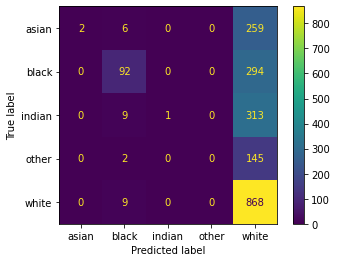

In [31]:
from sklearn.ensemble import RandomForestClassifier
unbal_rf_preds = cv_clf(RandomForestClassifier(max_depth=5), X_unbal, y_unbal)
unbal_rf_cf = ConfusionMatrixDisplay.from_predictions(y_unbal,unbal_rf_preds)
unbal_rf_cf

C:\Users\Lilly\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Lilly\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


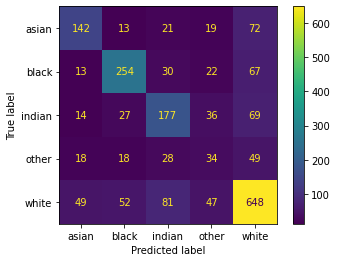

In [24]:
from sklearn.neural_network import MLPClassifier
unbal_mlp_preds = cv_clf(MLPClassifier(), X_unbal, y_unbal)
unbal_mlp_cm = ConfusionMatrixDisplay.from_predictions(y_unbal,unbal_mlp_preds)
unbal_mlp_cm

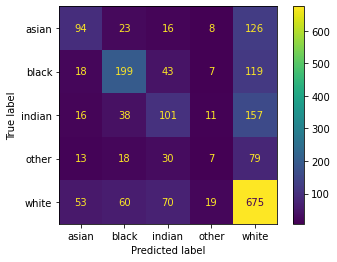

In [25]:
from sklearn.ensemble import AdaBoostClassifier
unbal_ada_preds = cv_clf(AdaBoostClassifier(), X_unbal, y_unbal)
unbal_ada_cm = ConfusionMatrixDisplay.from_predictions(y_unbal,unbal_ada_preds)
unbal_ada_cm

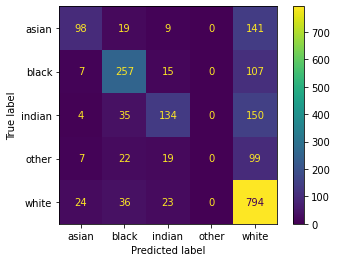

In [26]:
from sklearn.svm import SVC
unbal_svc_preds = cv_clf(SVC(), X_unbal, y_unbal)
unbal_svc_cm = ConfusionMatrixDisplay.from_predictions(y_unbal,unbal_svc_preds)
unbal_svc_cm

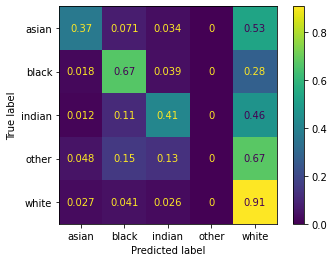

## Training Models on the Balanced Dataset

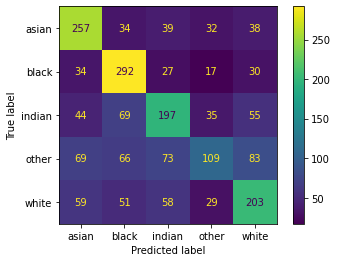

In [32]:
from sklearn.ensemble import RandomForestClassifier
bal_rf_preds = cv_clf(RandomForestClassifier(max_depth=5), X_bal, y_bal)
bal_rf_cm = ConfusionMatrixDisplay.from_predictions(y_bal,bal_rf_preds)
bal_rf_cm

C:\Users\Lilly\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Lilly\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Lilly\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Lilly\AppData

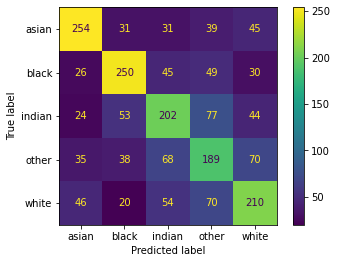

In [28]:
from sklearn.neural_network import MLPClassifier
bal_mlp_preds = cv_clf(MLPClassifier(), X_bal, y_bal)
bal_mlp_cm = ConfusionMatrixDisplay.from_predictions(y_bal,bal_mlp_preds)
bal_mlp_cm

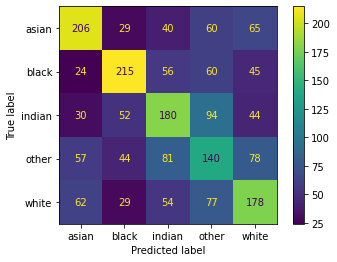

In [29]:
from sklearn.ensemble import AdaBoostClassifier
bal_ada_preds = cv_clf(AdaBoostClassifier(), X_bal, y_bal)
bal_ada_cm = ConfusionMatrixDisplay.from_predictions(y_bal,bal_ada_preds)
bal_ada_cm

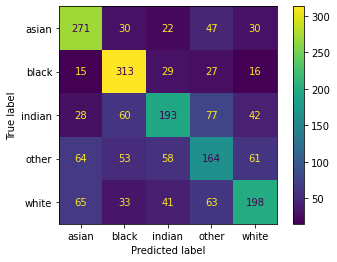

In [30]:
from sklearn.svm import SVC
bal_svc_preds = cv_clf(SVC(), X_bal, y_bal)
bal_svc_cm = ConfusionMatrixDisplay.from_predictions(y_bal,bal_svc_preds)
bal_svc_cm

## Confusion Matrix Comparisons
### Random forests

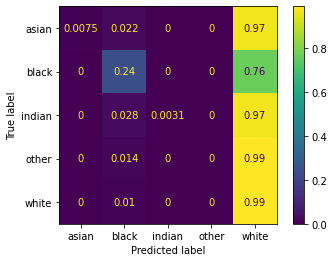

In [41]:
##unbalanced
norm_unbal_rf_cm = ConfusionMatrixDisplay.from_predictions(y_unbal,unbal_rf_preds,normalize='true')
norm_unbal_rf_cm

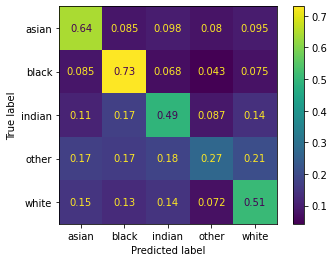

In [42]:
##balanced
norm_bal_rf_cm = ConfusionMatrixDisplay.from_predictions(y_bal,bal_rf_preds,normalize='true')
norm_bal_rf_cm

### Multi-Layer Peceptron

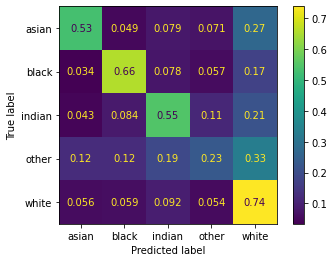

In [44]:
##unbalanced
norm_unbal_mlp_cm = ConfusionMatrixDisplay.from_predictions(y_unbal,unbal_mlp_preds,normalize='true')
norm_unbal_mlp_cm

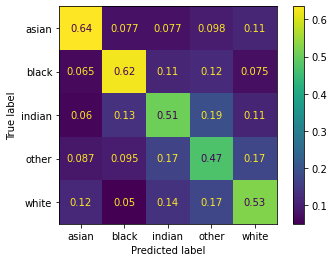

In [45]:
##balanced
norm_bal_mlp_cm = ConfusionMatrixDisplay.from_predictions(y_bal,bal_mlp_preds,normalize='true')
norm_bal_mlp_cm

### AdaBoost

In [ ]:
##unbalanced
norm_unbal_ada_cm = ConfusionMatrixDisplay.from_predictions(y_unbal,unbal_ada_preds,normalize='true')
norm_unbal_ada_cm

### SVC